In [1]:
import os, sys
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, PROJECT_ROOT)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from joblib import dump, load

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import VotingClassifier

from src.io_utils import load_df
from src.config import COLS, SEED
from src.eval_utils import compute_metrics, save_json, plot_confusion


In [3]:
X_TRAIN_PATH  = os.path.join(PROJECT_ROOT, "data/processed/X_train.csv")
Y_TRAIN_PATH  = os.path.join(PROJECT_ROOT, "data/processed/y_train.csv")
X_TEST_PATH   = os.path.join(PROJECT_ROOT, "data/processed/X_test.csv")
Y_TEST_PATH   = os.path.join(PROJECT_ROOT, "data/processed/y_test.csv")
# Optional SMOTE artifacts (from 02_prepare_features.ipynb)
X_TRAIN_SM_PATH = os.path.join(PROJECT_ROOT, "data/processed/X_train_sm.csv")
Y_TRAIN_SM_PATH = os.path.join(PROJECT_ROOT, "data/processed/y_train_sm.csv")

# (Optional) RF model path for ensemble
RF_MODEL_PATH = os.path.join(PROJECT_ROOT, "models/rf_baseline.pkl")

MODEL_PATH    = os.path.join(PROJECT_ROOT, "models/xgb_classifier.pkl")
REPORTS_JSON  = os.path.join(PROJECT_ROOT, "reports/xgb_metrics.json")
FIG_CM_RAW    = os.path.join(PROJECT_ROOT, "figures/xgb_confusion_raw.png")
FIG_CM_NORM   = os.path.join(PROJECT_ROOT, "figures/xgb_confusion_norm.png")
FIG_FEAT_IMP  = os.path.join(PROJECT_ROOT, "figures/xgb_feature_importance_gain.png")

In [4]:
X_train = load_df(X_TRAIN_PATH)
y_train = load_df(Y_TRAIN_PATH)["Target"]
X_test  = load_df(X_TEST_PATH)
y_test  = load_df(Y_TEST_PATH)["Target"]

print("Train:", X_train.shape, " Test:", X_test.shape)
print("Train class ratio:\n", y_train.value_counts(normalize=True).round(3))
print("Test  class ratio:\n",  y_test.value_counts(normalize=True).round(3))

Train: (3539, 18)  Test: (885, 18)
Train class ratio:
 Target
2    0.499
0    0.321
1    0.179
Name: proportion, dtype: float64
Test  class ratio:
 Target
2    0.499
0    0.321
1    0.180
Name: proportion, dtype: float64


In [5]:
# Build per-row sample weights from class counts (for ORIGINAL training set)
classes, counts = np.unique(y_train, return_counts=True)
class_weights = counts.sum() / (len(classes) * counts)          # shape: [num_classes]
row_weights = np.array([class_weights[c] for c in y_train])     # shape: [n_train]

# Detect optional SMOTE artifacts
USE_SMOTE_AVAILABLE = os.path.exists(X_TRAIN_SM_PATH) and os.path.exists(Y_TRAIN_SM_PATH)
print("SMOTE files available:", USE_SMOTE_AVAILABLE)


SMOTE files available: True


In [6]:
# ===== XGB with CV tuning (targeting macro-F1) =====
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

xgb = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    tree_method="hist",
    n_jobs=-1,
    random_state=SEED,
)

param_dist = {
  "n_estimators": [400, 600, 800],
  "learning_rate": [0.01, 0.05, 0.1],
  "max_depth": [4, 6, 8],
  "subsample": [0.6, 0.8, 1.0],
  "colsample_bytree": [0.6, 0.8, 1.0],
  "reg_lambda": [0.5, 1.0, 1.5],
  "gamma": [0, 1, 5],
}

# A) Weighted-original search
search = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    n_iter=40,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    random_state=SEED,
    verbose=1,
)
search.fit(X_train, y_train, sample_weight=row_weights)
xgb_weighted_best = search.best_estimator_
cv_weighted = search.best_score_
print("Best params (weighted original):", search.best_params_)
print("CV f1_macro (weighted original):", round(cv_weighted, 4))

# B) (Optional) SMOTE search without weights
xgb_smote_best, cv_smote = None, None
if USE_SMOTE_AVAILABLE:
    X_train_sm = load_df(X_TRAIN_SM_PATH)
    y_train_sm = load_df(Y_TRAIN_SM_PATH)["Target"]

    search_sm = RandomizedSearchCV(
        xgb,
        param_distributions=param_dist,
        n_iter=40,
        cv=cv,
        scoring="f1_macro",
        n_jobs=-1,
        random_state=SEED,
        verbose=1,
    )
    search_sm.fit(X_train_sm, y_train_sm)
    xgb_smote_best = search_sm.best_estimator_
    cv_smote = search_sm.best_score_
    print("Best params (SMOTE):", search_sm.best_params_)
    print("CV f1_macro (SMOTE):", round(cv_smote, 4))

# C) Pick the winner for test-time evaluation
model = xgb_weighted_best
train_used = "weighted_original"
if cv_smote is not None and cv_smote > cv_weighted:
    model = xgb_smote_best
    train_used = "smote"

print("Chosen model:", train_used)


Fitting 5 folds for each of 40 candidates, totalling 200 fits


Best params (weighted original): {'subsample': 1.0, 'reg_lambda': 1.0, 'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 0.6}
CV f1_macro (weighted original): 0.7169
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best params (SMOTE): {'subsample': 0.6, 'reg_lambda': 1.0, 'n_estimators': 600, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}
CV f1_macro (SMOTE): 0.8102
Chosen model: smote


In [7]:
y_pred = model.predict(X_test)

label_names = ["Dropout", "Graduate", "Enrolled"]
labels = sorted(y_train.unique())

metrics = compute_metrics(y_test, y_pred, labels=labels, label_names=label_names)
print("Accuracy:", round(metrics["accuracy"], 4))
print(pd.DataFrame(metrics["per_class"]).T)

save_json(metrics, REPORTS_JSON)
print("Saved metrics ->", REPORTS_JSON)


Accuracy: 0.7322
          precision    recall        f1  support
Dropout    0.774809  0.714789  0.743590    284.0
Graduate   0.409574  0.484277  0.443804    159.0
Enrolled   0.845977  0.832579  0.839225    442.0
Saved metrics -> /home/glinux/Projects/Skole/AnvendtData/reports/xgb_metrics.json


Saved confusion matrices -> /home/glinux/Projects/Skole/AnvendtData/figures/xgb_confusion_raw.png  &  /home/glinux/Projects/Skole/AnvendtData/figures/xgb_confusion_norm.png


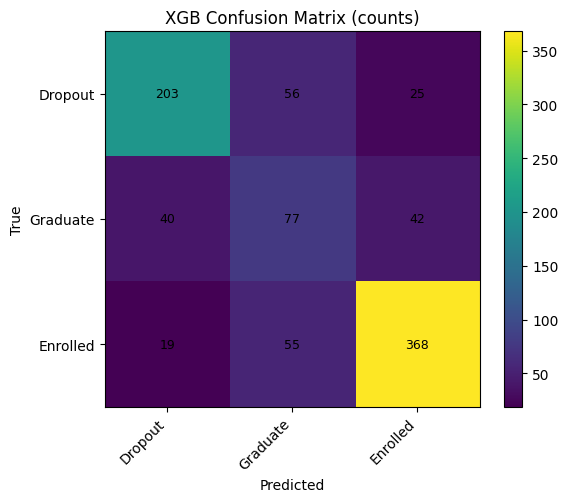

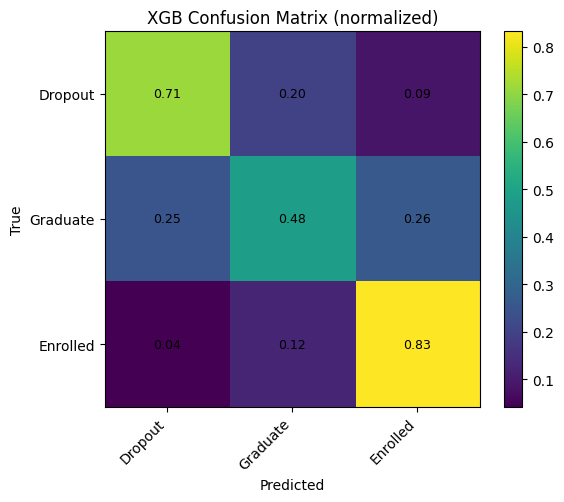

In [8]:
plot_confusion(y_test, y_pred, label_names=label_names, normalize=False,
               title="XGB Confusion Matrix (counts)", save_path=FIG_CM_RAW)
plot_confusion(y_test, y_pred, label_names=label_names, normalize=True,
               title="XGB Confusion Matrix (normalized)", save_path=FIG_CM_NORM)
print("Saved confusion matrices ->", FIG_CM_RAW, " & ", FIG_CM_NORM)

In [9]:
# Gain is more informative than default weight frequency
booster = model.get_booster()
gain_map = booster.get_score(importance_type="gain")  # dict: 'f0' -> gain

# Map XGB feature names to real column names by index
feat_names = {f"f{idx}": name for idx, name in enumerate(X_train.columns)}
gain_series = pd.Series({feat_names.get(k, k): v for k, v in gain_map.items()}).sort_values(ascending=True)

# Fallback if empty (rare)
if gain_series.empty and hasattr(model, "feature_importances_"):
    gain_series = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=True)

plt.figure(figsize=(7, 6))
gain_series.tail(15).plot(kind="barh")
plt.title("XGBoost — Top Feature Importance (Gain)")
plt.xlabel("Average Gain")
plt.tight_layout()
plt.savefig(FIG_FEAT_IMP, dpi=150, bbox_inches="tight")
plt.close()
print("Saved feature importance ->", FIG_FEAT_IMP)


Saved feature importance -> /home/glinux/Projects/Skole/AnvendtData/figures/xgb_feature_importance_gain.png


In [10]:
dump(model, MODEL_PATH)
print("Saved model ->", MODEL_PATH)


Saved model -> /home/glinux/Projects/Skole/AnvendtData/models/xgb_classifier.pkl



== Ensemble (RF + XGB) ==
Accuracy: 0.7492
          precision    recall        f1  support
Dropout    0.773234  0.732394  0.752260    284.0
Graduate   0.473282  0.389937  0.427586    159.0
Enrolled   0.810309  0.889140  0.847896    442.0
Saved ensemble metrics and matrices.


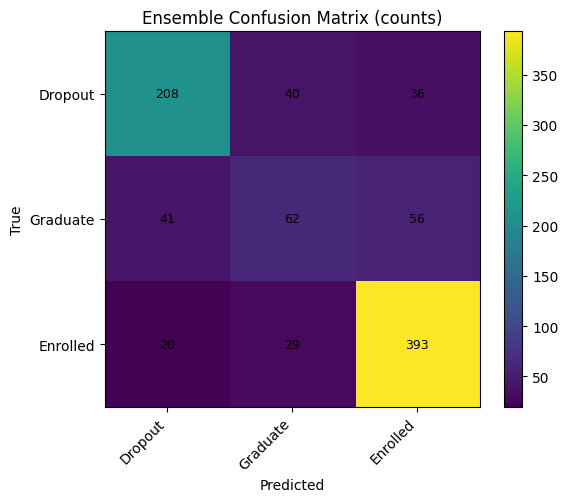

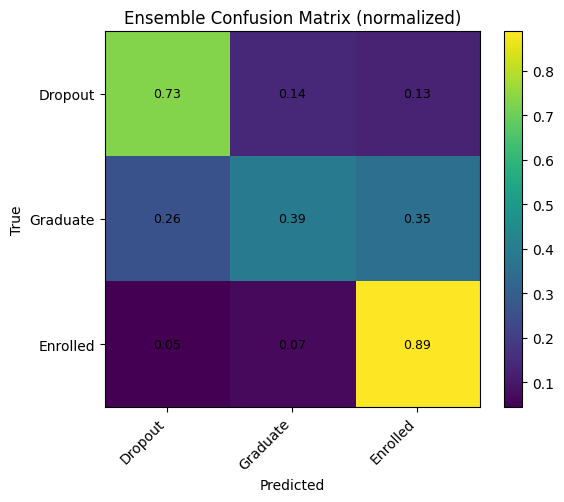

In [11]:
try:
    rf_model = load(RF_MODEL_PATH)

    ens = VotingClassifier(
        estimators=[("rf", rf_model), ("xgb", model)],
        voting="soft",
        n_jobs=-1
    )
    ens.fit(X_train, y_train)
    y_ens = ens.predict(X_test)

    ens_metrics = compute_metrics(y_test, y_ens, labels=labels, label_names=label_names)
    print("\n== Ensemble (RF + XGB) ==")
    print("Accuracy:", round(ens_metrics["accuracy"], 4))
    print(pd.DataFrame(ens_metrics["per_class"]).T)

    # Save ensemble metrics + confusions (optional separate files)
    ens_reports_json = os.path.join(PROJECT_ROOT, "reports/ensemble_metrics.json")
    ens_cm_raw = os.path.join(PROJECT_ROOT, "figures/ensemble_confusion_raw.png")
    ens_cm_norm = os.path.join(PROJECT_ROOT, "figures/ensemble_confusion_norm.png")

    save_json(ens_metrics, ens_reports_json)
    plot_confusion(y_test, y_ens, label_names=label_names, normalize=False,
                   title="Ensemble Confusion Matrix (counts)", save_path=ens_cm_raw)
    plot_confusion(y_test, y_ens, label_names=label_names, normalize=True,
                   title="Ensemble Confusion Matrix (normalized)", save_path=ens_cm_norm)
    print("Saved ensemble metrics and matrices.")

except Exception as e:
    print("Ensemble skipped (RF model not found or other issue):", e)
